# 데이터 명세서

### 학습 데이터 (user_id : 10000 ~ 24999, 15000명)


- train_err_data.csv : 시스템에 발생한 에러 로그

- train_quality_data.csv : 시스템 퀄리티 로그

- train_problem_data.csv : 사용자 불만 및 불만이 접수된 시간



### 테스트 데이터(user_id : 30000 ~ 44998, 14999명)


- test_err_data.csv : 시스템에 발생한 에러 로그

- test_quality_data.csv : 시스템 퀄리티 로그

- sample_submission.csv : 사용자 불만 확률(0~1) (제출용)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
import numpy as np
from tqdm import tqdm
import random
import datetime

In [3]:
# from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:80% !important; }</style>"))

In [61]:
tre = pd.read_csv("train_err_data.csv")
tse = pd.read_csv("test_err_data.csv")

tre.time =  pd.to_datetime(tre.time) # tre의 time열을 datatime 형태로
tse.time =  pd.to_datetime(tse.time)

In [62]:
tp = pd.read_csv("train_problem_data.csv")
tp.time = pd.to_datetime(tp.time.astype('str'))
p_user = tp.user_id.unique() # 불만을 접수한 고객
np_user = list(set(tre.user_id.unique())  - set(p_user))
# 에러가 있었음에도 불만을 접수하지 않은 고객(시스템에 에러로그가 발생한 고객 - 실제 불만을 접수한 고객)

In [63]:
tq = pd.read_csv("train_quality_data.csv")

tqq = tq[['time','user_id']].drop_duplicates().reset_index(drop=True)
tqq.time = pd.to_datetime(tqq.time.astype('str'))

C:\Users\Administrator\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (10,11,12) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


에러뜰경우 아래코드실행    
(train_err_datetime.csv 는 time 컬럼만 datetime으로 custom한것)

In [65]:
tre_raw = pd.read_csv('train_err_data.csv')
tp = pd.read_csv('train_problem_data.csv')

tpd=tp.user_id.value_counts().to_frame().reset_index()
tpd.columns = ['user_id','count_e']
tre = pd.merge(tre_raw,tpd,on='user_id',how='outer')
tre.count_e =tre.count_e.fillna(0).astype('int')

tse = pd.read_csv("test_err_data.csv")

tre.time =pd.to_datetime(tre.time.astype('str'))
tse.time =pd.to_datetime(tse.time.astype('str'))

컬럼명가져오기

In [66]:
def check_unique(col,df1,df2):
    def change_len(x):
        if len(x) == 10:
            return x[:5]  # 길이가 10이면 5로 맞춰줌.
        else:
            return x
    print("about",col)
    
    if col != 'fwvers':
        train_c = set(df1[col].unique())
        test_c  = set(df2[col].unique())
        print("train only in %s "%col, train_c - test_c)
        print("test only in %s "%col, test_c - train_c)
        total = (train_c | test_c)
        
    else:
        train_c = set(df1[col].apply(change_len).unique())
        test_c  = set(df2[col].apply(change_len).unique())
        print("train only in %s "%col,train_c-test_c)
        print("test only in %s "%col,test_c -train_c)
        total = (train_c | test_c)        
        
    print()
        
    return total

model_total=check_unique('model_nm',tre,tse)
errtype_total=check_unique('errtype',tre,tse)
fwver_total = check_unique('fwver',tre,tse)


about model_nm
train only in model_nm  set()
test only in model_nm  set()

about errtype
train only in errtype  set()
test only in errtype  set()

about fwver
train only in fwver  {'05.15.2122', '04.33.1095', '05.15.2090', '04.16.2641', '04.22.1442', '04.16.3345'}
test only in fwver  {'04.22.1170', '04.22.1448', '10.22.1780', '04.22.1772', '04.22.1478', '04.22.1608', '10.22.1770', '04.73.2577', '04.73.2569'}



각 데이터의 변환

# EDA

In [67]:
pd.options.display.max_columns = 50
pd.options.display.max_rows = 200

In [68]:
def get_distribution_errtype():
    total = []
    for num in range(1,43):
        t1=tre.loc[tre.errtype==num]
        
        t11=t1.user_id.value_counts().describe().to_frame().T.rename(index={'user_id':num})
        pnumber=len(t1.loc[t1.user_id.isin(p_user)].user_id.unique())
        npnumber=len(t1.loc[t1.user_id.isin(np_user)].user_id.unique())
        
        
        t11['p_counts'] =pnumber
        t11['npnumber'] =npnumber
        if pnumber+npnumber ==0:
            t11['p_ratio']  = round((pnumber/1)*100,2)
        else:
            t11['p_ratio']  = round((pnumber/(pnumber+npnumber))*100,2)
            
        total.append(t11)

    
    return pd.concat(total).reset_index().rename(columns={'index':'errtype'})

errtpye_distribution = get_distribution_errtype()

errtpye_distribution

,errtype,count,mean,std,min,25%,50%,75%,max,p_counts,npnumber,p_ratio
0,1,950.0,22.678947,18.943070,1.0,2.0,30.0,30.0,171.0,242,708,25.47
1,2,390.0,66.938462,352.626788,1.0,2.0,2.0,6.0,4056.0,168,222,43.08
2,3,1679.0,18.319238,210.186901,1.0,1.0,2.0,5.0,7284.0,465,1214,27.70
3,4,6881.0,188.453713,2778.822793,1.0,1.0,17.0,152.0,195228.0,2298,4583,33.40
4,5,11010.0,86.550409,261.247025,1.0,3.0,9.0,49.0,6637.0,4028,6982,36.58
5,6,6467.0,7.806092,47.292207,1.0,1.0,2.0,4.0,1796.0,2662,3805,41.16
6,7,7648.0,6.798248,46.755629,1.0,1.0,2.0,4.0,2687.0,3093,4555,40.44
7,8,64.0,2.593750,2.549315,1.0,1.0,2.0,3.0,19.0,13,51,20.31
8,9,63.0,1.730159,2.444258,1.0,1.0,1.0,1.0,17.0,38,25,60.32
9,10,2360.0,56.526695,1064.242805,1.0,1.0,2.0,6.0,49106.0,1134,1226,48.05


In [69]:
def make(num):
    err1=tre.loc[tre.errtype==num]
    users=err1.user_id.value_counts().to_frame().index
    t2 =err1.loc[err1.user_id.isin(users)]
    t2['err_'+str(num)] = t2.time.dt.hour

    p = t2.loc[t2.user_id.isin(p_user)]
    np = t2.loc[t2.user_id.isin(np_user)]

    pdf =p['err_'+str(num)].value_counts().sort_index().to_frame().T.rename(index={'err_'+str(num):'err_p_'+str(num)})
    npdf =np['err_'+str(num)].value_counts().sort_index().to_frame().T.rename(index={'err_'+str(num):'err_np_'+str(num)})

    f = pd.concat([pdf,npdf])
    f2= f.copy()
    f=f.fillna(0)
#     X_MinMax_scaled = minmax_scale(f, axis=1, copy=True)
#     f.iloc[:,:]=X_MinMax_scaled*100
    f=round(f)
    return f,f2

In [70]:
t = []
for v in range(1,43):
    if v==29:
        pass
    else:
        
        df,_ = make(v)
        t.append(df)


tt = pd.concat(t).fillna(0)

tv=tt.T.corr()

tv1=tv.loc[tv.index.str.contains('np')].iloc[:,::2]

d =[]
for v in range(41):
    if v==28:
        d.append(0)
        vv=tv1.iloc[v,v]
    else:  
        vv=tv1.iloc[v,v]
    d.append(vv)
codf = pd.DataFrame(d).reset_index().rename(columns={'index':'errtype',0:'n_np_cor_hour_counts'})
codf['errtype'] =codf['errtype']+1


### 에러타입별 빈도확인

In [71]:
pd.merge(codf,errtpye_distribution)

,errtype,n_np_cor_hour_counts,count,mean,std,min,25%,50%,75%,max,p_counts,npnumber,p_ratio
0,1,0.996303,950.0,22.678947,18.943070,1.0,2.0,30.0,30.0,171.0,242,708,25.47
1,2,0.396358,390.0,66.938462,352.626788,1.0,2.0,2.0,6.0,4056.0,168,222,43.08
2,3,0.301628,1679.0,18.319238,210.186901,1.0,1.0,2.0,5.0,7284.0,465,1214,27.70
3,4,0.762725,6881.0,188.453713,2778.822793,1.0,1.0,17.0,152.0,195228.0,2298,4583,33.40
4,5,0.975115,11010.0,86.550409,261.247025,1.0,3.0,9.0,49.0,6637.0,4028,6982,36.58
5,6,-0.237164,6467.0,7.806092,47.292207,1.0,1.0,2.0,4.0,1796.0,2662,3805,41.16
6,7,0.440525,7648.0,6.798248,46.755629,1.0,1.0,2.0,4.0,2687.0,3093,4555,40.44
7,8,-0.040990,64.0,2.593750,2.549315,1.0,1.0,2.0,3.0,19.0,13,51,20.31
8,9,0.566893,63.0,1.730159,2.444258,1.0,1.0,1.0,1.0,17.0,38,25,60.32
9,10,0.062688,2360.0,56.526695,1064.242805,1.0,1.0,2.0,6.0,49106.0,1134,1226,48.05


상관 관계가 높은 녀석들은 주목할 필요가 없다고 본다.      
err 13, err 14 ,err 42 에 대해 추가분석

In [72]:
def preprocessing_fw_update(target_df,mode='train'):
    if mode =='train':
        first_num = 10000
        count_num =15000
        
    else:
        first_num = 30000
        count_num =14999   
        
        
    dp = target_df[['user_id','model_nm','fwver']]

    unique_data =target_df[(dp !=dp.shift(1)).sum(axis=1)>0]

    fwver_total_dic ={}
    for v in range(len(fwver_total)):
        fwver_total_dic[sorted(list(fwver_total))[v]] = v+1

    def fwver_tran(x):
        return fwver_total_dic[x]

    fwver = np.zeros((count_num,21))
    for idx in tqdm(unique_data.user_id.unique()):
        df = unique_data.loc[unique_data.user_id==idx].fwver.values
        for l in range(len(df)):
            fwver[idx-first_num,l] =fwver_total_dic[df[l]]

    fw_df = pd.DataFrame(fwver).reset_index().rename(columns={'index':'user_id'})

    fwver_total_dic_rev = {v: k for k, v in fwver_total_dic.items()}
    fwver_total_dic_rev2 = fwver_total_dic_rev.copy()
    fwver_total_dic_rev[0] =0
    fwver_total_dic_rev2[0] = '04.22.1750'  #max 값
    

    def fwver_tras_reverse(x):
        return fwver_total_dic_rev[x]
    
    def fwver_tras_reverse2(x):
        return fwver_total_dic_rev2[x]
    
    fw_df[0] =fw_df[0].apply(fwver_tras_reverse2)
    fw_df[1] =fw_df[1].apply(fwver_tras_reverse)
    fw_df[2] =fw_df[2].apply(fwver_tras_reverse)
    fw_df[3] =fw_df[3].apply(fwver_tras_reverse)
    fw_df[4] =fw_df[4].apply(fwver_tras_reverse)

    fw_df['user_id'] +=first_num

    def model(x):
        if x in p_user:
            return 1
        else:
            return 0




    if mode =='train':
        fw_df['pb'] =fw_df.user_id.apply(model)

        fw_df2=fw_df.loc[fw_df.pb ==1]
        pfw = fw_df2[[0,1,2,3,4]].value_counts().to_frame().rename(columns={0:'problem'}).reset_index().sort_values(0)\
        .rename(columns={0:'fw1',1:'fw2',2:'fw3',3:'fw4',4:'fw5'}).reset_index(drop=True)

        fw_df2=fw_df.loc[fw_df.pb ==0]
        npfw = fw_df2[[0,1,2,3,4]].value_counts().to_frame().rename(columns={0:'non-problem'}).reset_index().sort_values(0)\
        .rename(columns={0:'fw1',1:'fw2',2:'fw3',3:'fw4',4:'fw5'}).reset_index(drop=True)

        fw_t= fw_df[[0,1,2,3,4]].value_counts().to_frame().rename(columns={0:'counts'}).reset_index().sort_values(0)\
        .rename(columns={0:'fw1',1:'fw2',2:'fw3',3:'fw4',4:'fw5'}).reset_index(drop=True)
        s1=pd.merge(fw_t,pfw,how='outer').fillna(0)
        s2=pd.merge(s1,npfw,how='outer').fillna(0)
        s2['problem'] =s2['problem'].astype('int')
        s2['non-problem'] =s2['non-problem'].astype('int')
        s2['problem-ratio'] = round(s2['problem']/s2['counts'] *100,2)
        return s2

    else:
        fw_t= fw_df[[0,1,2,3,4]].value_counts().to_frame().rename(columns={0:'counts'}).reset_index().sort_values(0)\
        .rename(columns={0:'fw1',1:'fw2',2:'fw3',3:'fw4',4:'fw5'}).reset_index(drop=True)
        return fw_t

In [73]:
fw_ts = preprocessing_fw_update(tse,'test')
fw_tr = preprocessing_fw_update(tre,'train')

100%|██████████████████████████████████████████████████████████████████████████| 15000/15000 [00:10<00:00, 1464.28it/s]


In [74]:
fw_ts=fw_ts.rename(columns={'counts':'test_c'})
fw_tr=fw_tr.rename(columns={'counts':'train_c'})
fw_totals = pd.merge(fw_tr,fw_ts,how='outer')[['fw1','fw2','fw3','fw4','fw5','problem','non-problem','problem-ratio','train_c','test_c']].fillna(0)

## fwver change table

test, train set의 펌웨어 변화 과정을 나타냄, 분포가 비슷함을 확인할수 있다

In [75]:
fw_totals

,fw1,fw2,fw3,fw4,fw5,problem,non-problem,problem-ratio,train_c,test_c
0,03.11.1141,0,0,0,0,0.0,1.0,0.00,1.0,2.0
1,03.11.1141,03.11.1167,0,0,0,1.0,0.0,100.00,1.0,0.0
2,03.11.1149,0,0,0,0,0.0,5.0,0.00,5.0,4.0
3,03.11.1149,03.11.1167,0,0,0,0.0,1.0,0.00,1.0,1.0
4,03.11.1167,04.33.1149,04.33.1261,0,0,2.0,0.0,100.00,2.0,0.0
5,03.11.1167,0,0,0,0,133.0,540.0,19.76,673.0,680.0
6,03.11.1167,04.33.1261,0,0,0,2.0,0.0,100.00,2.0,3.0
7,04.16.2641,04.33.1261,0,0,0,1.0,0.0,100.00,1.0,0.0
8,04.16.3345,04.33.1185,04.33.1261,0,0,1.0,0.0,100.00,1.0,0.0
9,04.16.3345,0,0,0,0,0.0,1.0,0.00,1.0,0.0


아래의 녀석들이 대부분의 비율을 차지하므로 이친구들로 만들수 있는 파생변수를 확인

In [76]:
fw_totals.loc[fw_totals.train_c >100].sort_values('train_c',ascending=False)

,fw1,fw2,fw3,fw4,fw5,problem,non-problem,problem-ratio,train_c,test_c
42,04.22.1750,04.22.1778,0,0,0,1542.0,2564.0,37.55,4106.0,4184.0
59,04.33.1185,04.33.1261,0,0,0,940.0,2239.0,29.57,3179.0,3126.0
86,05.15.2138,0,0,0,0,662.0,2345.0,22.02,3007.0,3014.0
16,04.16.3553,0,0,0,0,569.0,1284.0,30.71,1853.0,1873.0
5,03.11.1167,0,0,0,0,133.0,540.0,19.76,673.0,680.0
63,04.33.1261,0,0,0,0,141.0,371.0,27.54,512.0,486.0
17,04.16.3553,04.16.3571,04.16.3553,0,0,173.0,204.0,45.89,377.0,420.0
21,04.16.3553,04.33.1261,0,0,0,250.0,17.0,93.63,267.0,242.0
44,04.22.1750,0,0,0,0,39.0,118.0,24.84,157.0,126.0
25,04.16.3553,04.33.1185,04.33.1261,0,0,135.0,10.0,93.10,145.0,153.0


## visualization

모델 변화에 따른 errtype code의 시각화

In [77]:
### model - fwver -labling

mode = 'train'
target_df = tre
if mode =='train':
    first_num = 10000
    count_num =15000

else:
    first_num = 30000
    count_num =14999   


dp = target_df[['user_id','model_nm','fwver']]
unique_data =target_df[(dp !=dp.shift(1)).sum(axis=1)>0]

dp2 = target_df[['user_id','model_nm']]
unique_data2 =target_df[(dp2 !=dp2.shift(1)).sum(axis=1)>0]

fwver_total_dic ={}
for v in range(len(fwver_total)):
    fwver_total_dic[sorted(list(fwver_total))[v]] = v+1
    


def fwver_tran(x):
    return fwver_total_dic[x]

fwver = np.zeros((count_num,24))
for idx in tqdm(unique_data.user_id.unique()):
    df_md =unique_data2.loc[unique_data2.user_id==idx].model_nm.values
    df_fw = unique_data.loc[unique_data.user_id==idx].fwver.values
    
    for md in range(len(df_md)):
        fwver[idx-first_num,md] = int(df_md[md][-1])+1
    
    for l in range(3,len(df_fw)+3):
        fwver[idx-first_num,l] =fwver_total_dic[df_fw[l-3]]

fw_df = pd.DataFrame(fwver).reset_index().rename(columns={'index':'user_id'})

fwver_total_dic_rev = {v: k for k, v in fwver_total_dic.items()}
fwver_total_dic_rev2 = fwver_total_dic_rev.copy()
fwver_total_dic_rev[0] =0
fwver_total_dic_rev2[0] = '04.22.1750'  #max 값


def fwver_tras_reverse(x):
    return fwver_total_dic_rev[x]

def fwver_tras_reverse2(x):
    return fwver_total_dic_rev2[x]

fw_df[3] =fw_df[3].apply(fwver_tras_reverse2)
fw_df[4] =fw_df[4].apply(fwver_tras_reverse)
fw_df[5] =fw_df[5].apply(fwver_tras_reverse)
fw_df[6] =fw_df[6].apply(fwver_tras_reverse)
fw_df[7] =fw_df[7].apply(fwver_tras_reverse)


fw_df = fw_df.rename(columns={0:'md1',1:'md2',2:'md3',3:'fw1',4:'fw2',5:'fw3',6:'fw4',7:'fw5'})
fw_df['user_id'] =fw_df['user_id']+10000

100%|███████████████████████████████████████████████████████████████████████████| 15000/15000 [00:20<00:00, 739.90it/s]


In [78]:
def dr(num):
    user_id_idx = uid1.values[num]
    err_idx = df.loc[df.user_id ==user_id_idx]
    p_idx =df_p.loc[df_p.user_id ==user_id_idx]
    flow_idx = fw_df.loc[fw_df.user_id ==user_id_idx].iloc[:,:9]

    
    
    print("fwver_flow")
    display(flow_idx)
    print("problem time")
    display(p_idx)
    print('user err distribution')
    display(err_idx.errcode.value_counts().to_frame().T)

        
        
    fig ,axes = plt.subplots(2,1,figsize=(20,10))

    sns.scatterplot(data=err_idx,x='time' ,y='errtype',hue='fwver',s=7,ax=axes[0])
    if len(p_idx) !=0:
        for v in range(len(p_idx)):
            axes[0].axvline(p_idx.time.values[v],c='r',linestyle='--',label='prblem occur')
        
    start_date = pd.to_datetime("2020-11-01 11:00:00")
    for v in range(30):
        axes[0].axvline(start_date,c='y',linestyle='--',label='11:00')
        start_date +=datetime.timedelta(days=1)
        
        
    tqdf = tqq.loc[tqq.user_id ==user_id_idx]
    for tqs in range(len(tqdf)):
        axes[0].axvline(tqdf.time.values[tqs],c='b',linestyle='--',label='quality',alpha=0.5)
    
    axes[0].set_xlim(pd.to_datetime('2020-11-01'),pd.to_datetime('2020-11-30 23:00:00'))
    axes[0].set_title('errtype -fw, user_id :'+str(user_id_idx))
    handles, labels = axes[0].get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    axes[0].legend(by_label.values(), by_label.keys(),bbox_to_anchor=(1.05, 1), loc='upper left')
#     for idxs in err_idx.errcode.value_counts().to_frame().index:
#         code_df=err_idx.loc[err_idx.errcode ==idxs]


    sns.scatterplot(data=err_idx,x='time' ,y='errcode',hue='errtype',s=15,ax=axes[1], palette='tab20c')
    axes[1].set_xlim(pd.to_datetime('2020-11-01'),pd.to_datetime('2020-11-30 23:00:00'))
    axes[1].set_title('errcode -fw')
    axes[1].legend(title='errtype',bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

In [79]:
fw_tr.sort_values(['train_c','problem'],ascending=False)

,fw1,fw2,fw3,fw4,fw5,train_c,problem,non-problem,problem-ratio
42,04.22.1750,04.22.1778,0,0,0,4106,1542,2564,37.55
59,04.33.1185,04.33.1261,0,0,0,3179,940,2239,29.57
86,05.15.2138,0,0,0,0,3007,662,2345,22.02
16,04.16.3553,0,0,0,0,1853,569,1284,30.71
5,03.11.1167,0,0,0,0,673,133,540,19.76
63,04.33.1261,0,0,0,0,512,141,371,27.54
17,04.16.3553,04.16.3571,04.16.3553,0,0,377,173,204,45.89
21,04.16.3553,04.33.1261,0,0,0,267,250,17,93.63
44,04.22.1750,0,0,0,0,157,39,118,24.84
25,04.16.3553,04.33.1185,04.33.1261,0,0,145,135,10,93.10


In [80]:
check_list = []

## 원하는 펌웨어 변경순서 입력후 확인하고싶은 만큼 출력

In [81]:

uid1 = fw_df.loc[(fw_df.fw1 =='04.22.1750') &(fw_df.fw2 =='04.22.1778')&(fw_df.fw3 ==0)].user_id
len(uid1)
df= tre.loc[tre.user_id.isin(uid1)]
df_p =tp.loc[tp.user_id.isin(uid1)]

fwver_flow


,user_id,md1,md2,md3,fw1,fw2,fw3,fw4,fw5
4,10004,1.0,0.0,0.0,04.22.1750,04.22.1778,0,0,0


problem time


,user_id,time
492,10004,20201104120000


user err distribution


,1,connection timeout,0,2,14,active,standby,3,13,terminate by peer user,8.0,connection fail to establish
errcode,529,104,98,14,9,7,5,4,3,2,1,1


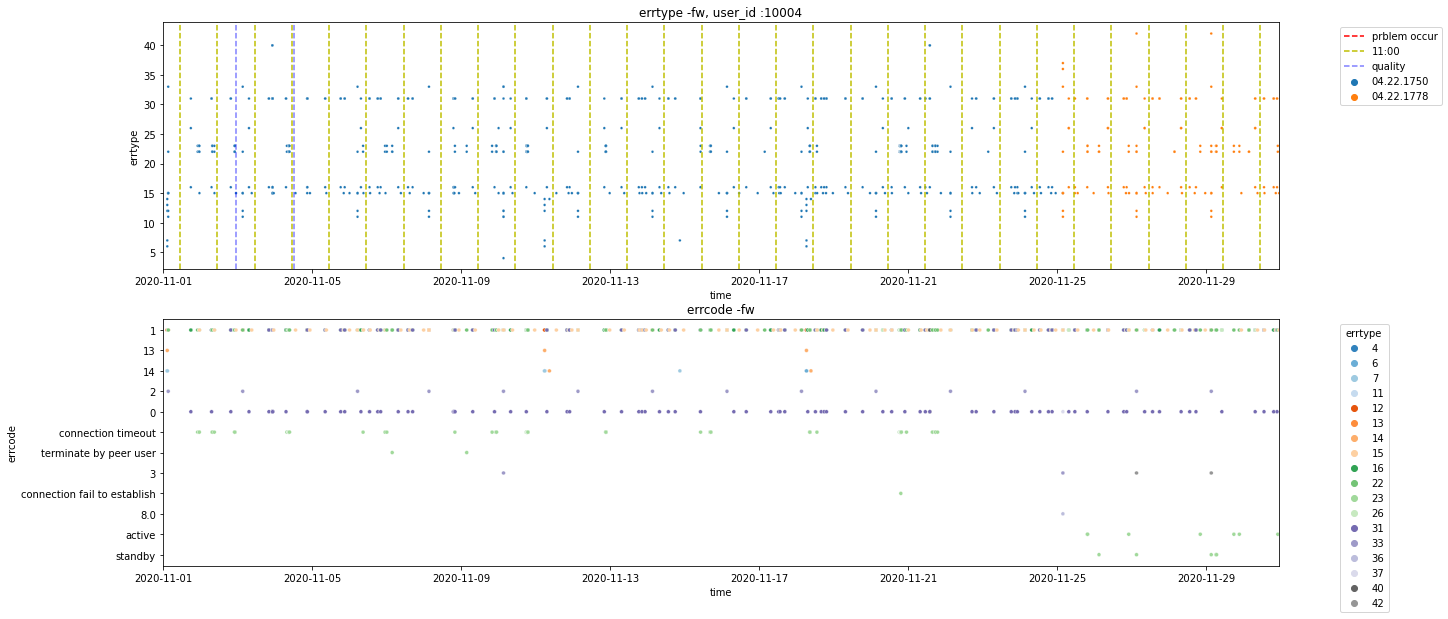

fwver_flow


,user_id,md1,md2,md3,fw1,fw2,fw3,fw4,fw5
5,10005,1.0,0.0,0.0,04.22.1750,04.22.1778,0,0,0


problem time


,user_id,time
3857,10005,20201113120000


user err distribution


,1,B-A8002,0,NFANDROID2,connection timeout,2,3,terminate by peer user,standby,14,8.0,active
errcode,384,176,88,61,13,12,4,4,3,2,1,1


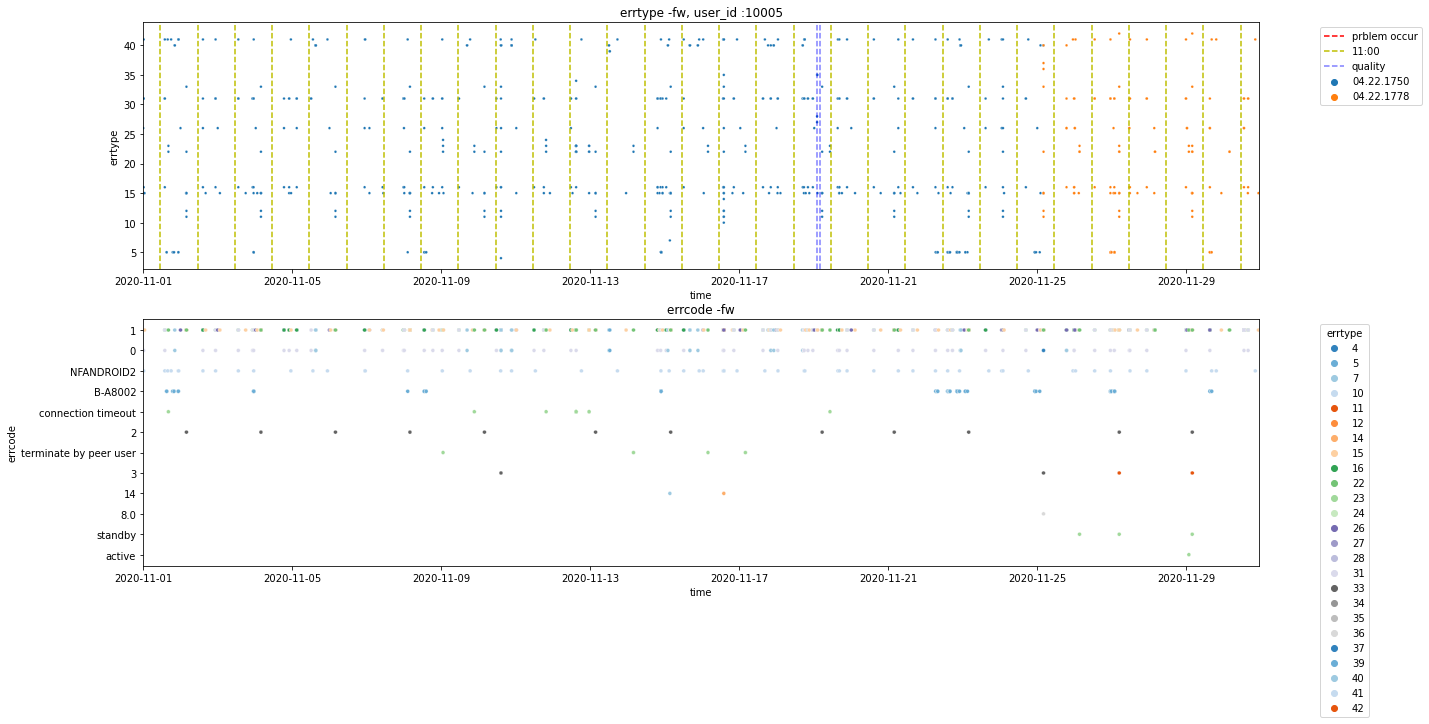

In [82]:
for v in range(2):
    dr(v)

## 랜덤으로 하나출력

fwver_flow


,user_id,md1,md2,md3,fw1,fw2,fw3,fw4,fw5
1155,11155,1.0,0.0,0.0,04.22.1750,04.22.1778,0,0,0


problem time


,user_id,time
2267,11155,20201110170000


user err distribution


,1,0,2,14,4,8.0,13
errcode,288,77,13,4,1,1,1


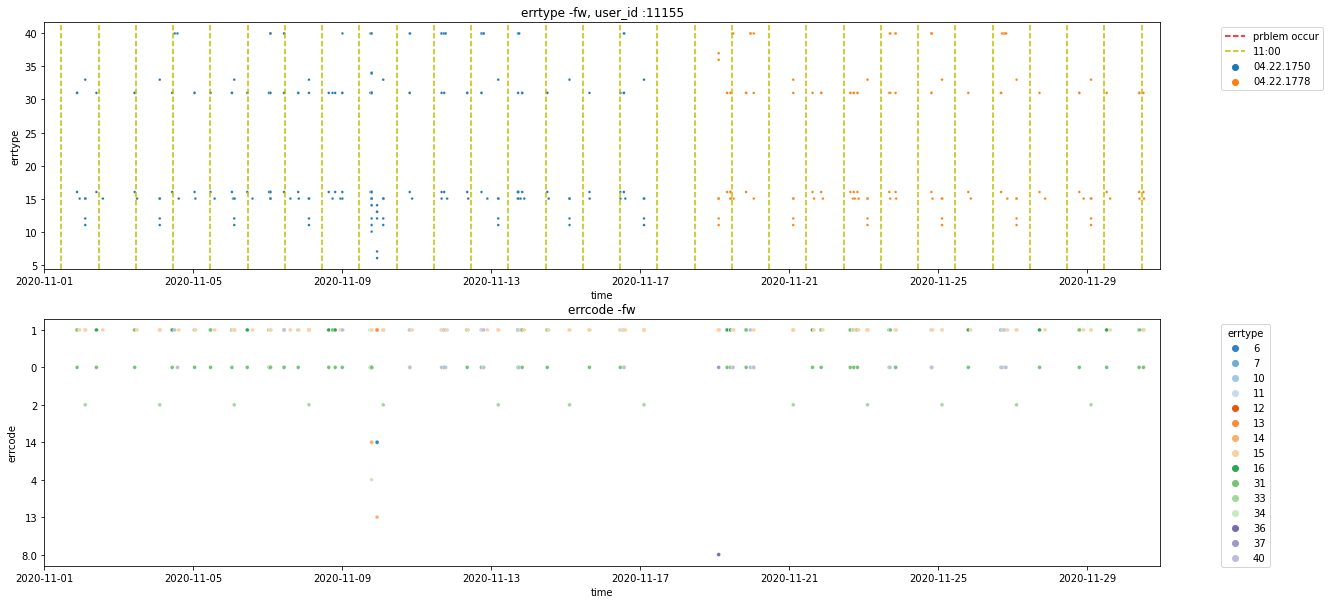

In [83]:
import random
while True:
    nums = random.randint(0,673)
    if nums in check_list:
        pass
    else:
        check_list +=[nums]
        break

dr(nums)

In [84]:
tr_pb =tp

AttributeError: Can only use .dt accessor with datetimelike values

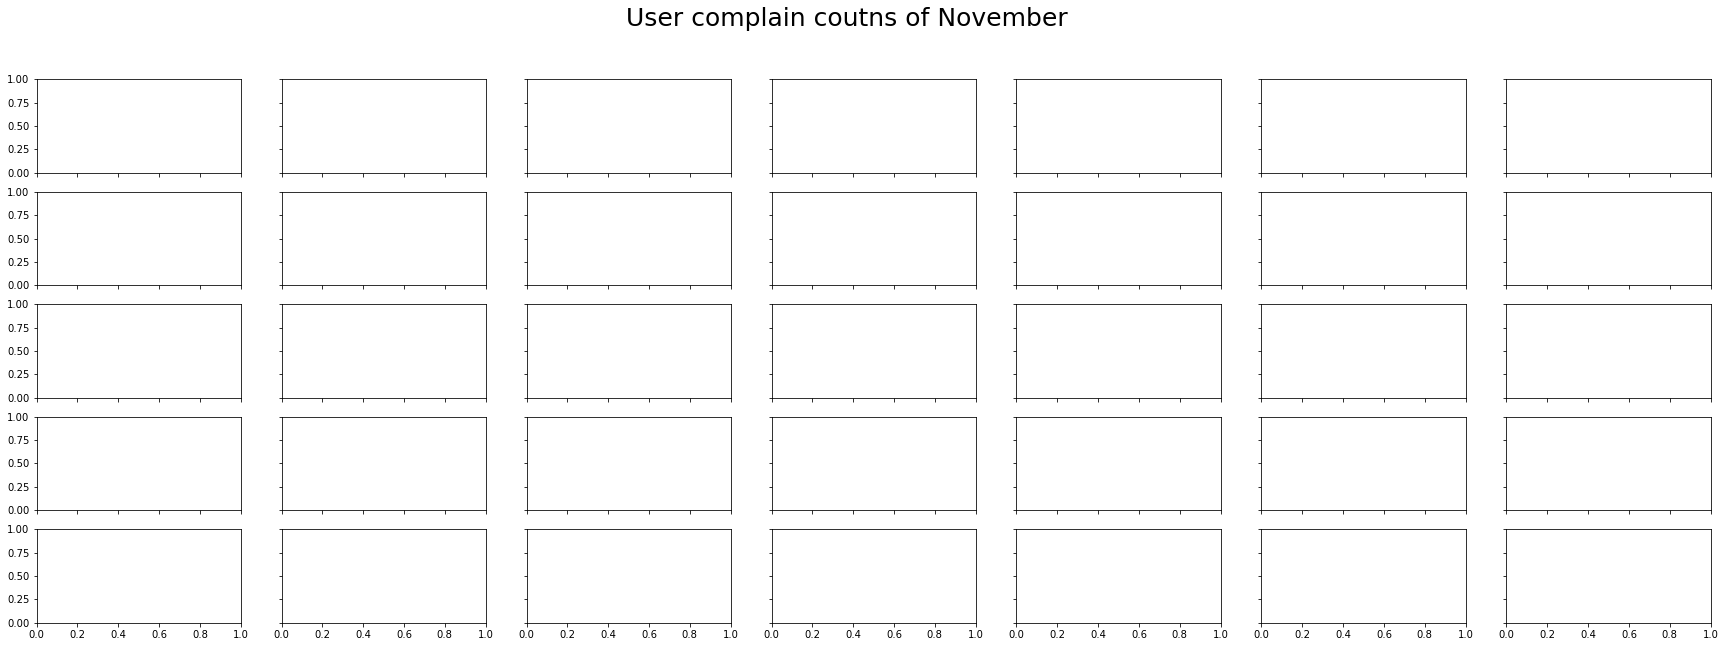

In [85]:
fig , axs = plt.subplots(nrows=5,ncols=7,figsize=(30,10), sharex=True, sharey=True)
plt.suptitle("User complain coutns of November", size=25)

date = pd.to_datetime('2020-11-01')

for days in range(32):
    rows =days//7
    cols =days%7
    
    
    date_time = tr_pb.loc[tr_pb.time.dt.date==date]
    loc_df = date_time.time.dt.hour.value_counts().sort_index()
    
    dic_new = loc_df.to_dict()

    for v in range(0,24):
        if v not in dic_new.keys():
            dic_new[v] =0

    dic2={}
    for vv in range(24):
        dic2[vv] = dic_new[vv]

    df= pd.DataFrame(dic2.items())
    df.columns = ['time','counts']

    axs[rows,cols].bar(range(24),df.counts.values)  
    axs[rows,cols].set_title(str(date)[:-9]+"  "+date.day_name())
    axs[rows,cols].set_xticks(range(0,24,2))
    axs[rows,cols].set_ylim(0,45)
    date += datetime.timedelta(days=1)

fig.text(0.5, -0.02, 'Hours', ha='center',fontsize=18)
fig.text(-0.006, 0.5, 'Complain_counts', va='center', rotation='vertical',fontsize=18)
    
fig.tight_layout()

주단위에서 월요일에 최대 발생,     
시간단위 오전중에 잠잠하다 오후에 크게발생    

# 모델 변화가 존재한 유저들의 문제 발생시점파악

In [ ]:
v=tre[['user_id','model_nm']]
getdf =~(v == v.shift(1))
logical =(getdf.user_id.apply(int) + getdf.model_nm.apply(int)) > 0
tre_model_counts=v[logical]

In [ ]:
user_id_2_model = tre_model_counts.user_id.value_counts()
user_id_lst_2_model=list(user_id_2_model.loc[user_id_2_model ==2].to_frame().index)
sort_two_model_user = tre.loc[tre.user_id.isin(user_id_lst_2_model)].drop_duplicates(['user_id','model_nm'],keep='last').drop_duplicates('user_id',keep='first').sort_values("time").user_id

In [ ]:
plt.figure(figsize=(20,8))
for i,value in enumerate(sort_two_model_user):
    smt = tre.loc[tre.user_id ==value]
    p_time = tp.loc[tp.user_id ==value].time.values
    sns.scatterplot(data=smt,x='time',y=np.ones(len(smt))*i,hue='model_nm',s=1)
    plt.scatter(p_time,np.ones(len(p_time))*i,c='r',s=3,label='problem occur')
 
    
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
lgnd=plt.legend(list(by_label.values())[:3], ['model_a','model_b','problem_occur'],loc='upper right', prop={'size': 15})
lgnd.legendHandles[2]._sizes =[40]
plt.title("Train_error data Problem occur when changing models",fontsize=20)
plt.xlabel("Time",fontsize=15)
plt.ylabel("users ",fontsize=15)

대부분 모델 (or fwver)의 변화시점에 존재함을 알수 있다.

# 파생변수 생성

In [86]:
def check_unique(col,df1,df2):
    def change_len(x):
        if len(x) ==10:
            return x[:5]
        else:
            return x
    print("about",col)
    if col !='fwvers':
        train_c = set(df1[col].unique())
        test_c  = set(df2[col].unique())
        print("train only in %s "%col,train_c-test_c)
        print("test only in %s "%col,test_c -train_c)
        total = (train_c | test_c)
    else:
        train_c = set(df1[col].apply(change_len).unique())
        test_c  = set(df2[col].apply(change_len).unique())
        print("train only in %s "%col,train_c-test_c)
        print("test only in %s "%col,test_c -train_c)
        total = (train_c | test_c)        
        
    print()
        
    return total

model_total=check_unique('model_nm',tre,tse)
errtype_total=check_unique('errtype',tre,tse)
fwver_total = check_unique('fwver',tre,tse)


about model_nm
train only in model_nm  set()
test only in model_nm  set()

about errtype
train only in errtype  set()
test only in errtype  set()

about fwver
train only in fwver  {'05.15.2122', '04.33.1095', '05.15.2090', '04.16.2641', '04.22.1442', '04.16.3345'}
test only in fwver  {'04.22.1170', '04.22.1448', '10.22.1780', '04.22.1772', '04.22.1478', '04.22.1608', '10.22.1770', '04.73.2577', '04.73.2569'}



In [87]:
def dataset_trans(df,types,Num_df_user,Num_errtype,First_index):
    
    
    num_df_user = Num_df_user
    num_errtype =Num_errtype
    first_index = First_index
    num_model_change =2

    
    #----------------------------------------------errtype
    errtypes = np.zeros((num_df_user,num_errtype))
    err = df[['user_id','errtype']].values

    for inx, value in tqdm(err):
        errtypes[inx-first_index,value-1] +=1


    # ---------------------------------------------model_change
    v=df[['user_id','model_nm']]
    getdf =~(v == v.shift(1))
    logical =(getdf.user_id.apply(int) + getdf.model_nm.apply(int)) > 0
    df_model_counts =v[logical]


    def get_model_change_id(num):
        df_mc = df_model_counts.user_id.value_counts()
        df_mc_user=list(df_mc.loc[df_mc ==num].to_frame().index)
        sort_mc_user = df.loc[df.user_id.isin(df_mc_user)].drop_duplicates(['user_id','model_nm'],keep='last').drop_duplicates('user_id',keep='first').sort_values("time").user_id
        return sort_mc_user.values

    one_m = get_model_change_id(1)
    two_m = get_model_change_id(2)
    thr_m = get_model_change_id(3)


    model_n = np.zeros((num_df_user,num_model_change))
    df['model_f'] =df['model_nm'].str[-1].astype('int')
    one_df = df.loc[df.user_id.isin(one_m)][['user_id','model_f']].drop_duplicates().values
    two_df =df.loc[df.user_id.isin(two_m)][['user_id','model_f']].drop_duplicates().reset_index(drop=True)
    two_df['tf'] = two_df.index%2
    two_df= two_df.pivot(index='user_id',columns='tf').reset_index().values
    thr_df = df.loc[df.user_id.isin(thr_m)][['user_id','model_f']].drop_duplicates().values

    for inx, value in tqdm(one_df):
        model_n[inx-first_index,0]  +=value
    for inx, value1,value2 in tqdm(two_df):
        model_n[inx-first_index,0]  +=value1
        model_n[inx-first_index,1]  +=value2

    for inx, value in tqdm(thr_df):
        model_n[inx-first_index,0]  +=value


    # ---------------------------------------------fw change
    fwver_total_dic ={}
    for v in range(len(fwver_total)):
        fwver_total_dic[sorted(list(fwver_total))[v]] = v+1

    def fwver_tran(x):
        return fwver_total_dic[x]


    df['ver_num'] = df['fwver'].apply(fwver_tran)
    fwver_np = np.zeros((num_df_user,5))

    v3=df[['user_id','ver_num']]
    getdf =~(v3 == v3.shift(1))
    logical =(getdf.user_id.apply(int) + getdf.ver_num.apply(int)) > 0
    fwver_num=v3[logical]

    fwver_num = fwver_num.reset_index(drop=True)
    count =np.zeros(len(fwver_num),dtype=int)

    for v in range(1,len(fwver_num)):
        if fwver_num.user_id.values[v-1] ==fwver_num.user_id.values[v]:
            count[v] = count[v-1] +1


    fwver_num['count'] =count
    fw_v = fwver_num.loc[fwver_num['count'].isin([0,1,2,3,4])].pivot(index='user_id',columns='count').reset_index().fillna(0).values
    fw_v =fw_v.astype('int64')

    
    
    
    for inx, v1,v2,v3,v4,v5 in tqdm(fw_v):
        fwver_np[inx-first_index,0] =v1
        fwver_np[inx-first_index,1] =v2
        fwver_np[inx-first_index,2] =v3
        fwver_np[inx-first_index,3] =v4
        fwver_np[inx-first_index,4] =v5

    #---------------------------------------------------------- errtype_ mean_std
    df['week'] =df.time.dt.isocalendar().week

    df = df.loc[(df.time >=pd.to_datetime('2020-11-01 00:00:00')) &(df.time <=pd.to_datetime('2020-11-30 23:59:59'))]
    datas = df[['user_id','errtype','week']]
    df_=datas[['user_id','week','errtype']].value_counts().to_frame().reset_index()
    df_ =df_.sort_values(['user_id','week']).rename(columns = {0:'counts'}).reset_index(drop=True)

    df1 =df_.loc[df_.week ==44][['user_id','errtype','counts']].values
    df2 =df_.loc[df_.week ==45][['user_id','errtype','counts']].values
    df3 =df_.loc[df_.week ==46][['user_id','errtype','counts']].values
    df4 =df_.loc[df_.week ==47][['user_id','errtype','counts']].values
    df5 =df_.loc[df_.week ==48][['user_id','errtype','counts']].values

    day_data = np.zeros((num_df_user,42,5))
    for i, dfa in enumerate([df1,df2,df3,df4,df5]):
        for inx , val1 ,val2 in tqdm(dfa):
            day_data[:,:,i][inx-first_index,val1-1] = val2

    m=day_data.mean(axis=2)
    std=day_data.std(axis=2)       
        

        
        
    #----------------------------------------------------------- qulitydata
        
    #----------------------------------------------------------- errtype_ mean_std _of hour

    df['hour'] =df.time.dt.hour


    df = df.loc[(df.time >=pd.to_datetime('2020-11-01 00:00:00')) &(df.time <=pd.to_datetime('2020-11-30 23:59:59'))]
    datas = df[['user_id','errtype','hour']]
    df_=datas[['user_id','hour','errtype']].value_counts().to_frame().reset_index()
    df_ =df_.sort_values(['user_id','hour']).rename(columns = {0:'counts'}).reset_index(drop=True)


    day_data = np.zeros((num_df_user,42,24))
    for i in range(24):
        dfa = df_.loc[df_['hour']==i][['user_id','errtype','counts']].values
        for inx , val1 ,val2 in tqdm(dfa):
            day_data[:,:,i][inx-first_index,val1-1] = val2

    m2=day_data.mean(axis=2)
    std2=day_data.std(axis=2)       

    m2_1=day_data.max(axis=2)
    #----------------------------------------------------------- errtype_ mean_std _of day

    df['day'] =df.time.dt.day


    df = df.loc[(df.time >=pd.to_datetime('2020-11-01 00:00:00')) &(df.time <=pd.to_datetime('2020-11-30 23:59:59'))]
    datas = df[['user_id','errtype','day']]
    df_=datas[['user_id','day','errtype']].value_counts().to_frame().reset_index()
    df_ =df_.sort_values(['user_id','day']).rename(columns = {0:'counts'}).reset_index(drop=True)


    day_data = np.zeros((num_df_user,42,30))
    for i in range(30):
        dfa = df_.loc[df_['day']==(i+1)][['user_id','errtype','counts']].values
        for inx , val1 ,val2 in tqdm(dfa):
            day_data[:,:,i][inx-first_index,val1-1] = val2

    m3=day_data.mean(axis=2)
    std3=day_data.std(axis=2)       

    m3_1=day_data.max(axis=2) 
    
    
    
    
    
    #------------------------------------------------------------- fwver flow
    target_df = df
    first_num = first_index
    count_num =num_df_user

    dp = target_df[['user_id','model_nm','fwver']]
    unique_data =target_df[(dp !=dp.shift(1)).sum(axis=1)>0]

    dp2 = target_df[['user_id','model_nm']]
    unique_data2 =target_df[(dp2 !=dp2.shift(1)).sum(axis=1)>0]

    fwver_total_dic ={}
    for v in range(len(fwver_total)):
        fwver_total_dic[sorted(list(fwver_total))[v]] = v+1
    


    def fwver_tran(x):
        return fwver_total_dic[x]

    fwver = np.zeros((count_num,24))
    for idx in tqdm(unique_data.user_id.unique()):
        df_md =unique_data2.loc[unique_data2.user_id==idx].model_nm.values
        df_fw = unique_data.loc[unique_data.user_id==idx].fwver.values

        for md in range(len(df_md)):
            fwver[idx-first_num,md] = int(df_md[md][-1])+1

        for l in range(3,len(df_fw)+3):
            fwver[idx-first_num,l] =fwver_total_dic[df_fw[l-3]]

    fw_df = pd.DataFrame(fwver).reset_index().rename(columns={'index':'user_id'})

    fwver_total_dic_rev = {v: k for k, v in fwver_total_dic.items()}
    fwver_total_dic_rev2 = fwver_total_dic_rev.copy()
    fwver_total_dic_rev[0] =0
    fwver_total_dic_rev2[0] = '04.22.1750'  #max 값


    def fwver_tras_reverse(x):
        return fwver_total_dic_rev[x]

    def fwver_tras_reverse2(x):
        return fwver_total_dic_rev2[x]

    fw_df[3] =fw_df[3].apply(fwver_tras_reverse2)
    fw_df[4] =fw_df[4].apply(fwver_tras_reverse)
    fw_df[5] =fw_df[5].apply(fwver_tras_reverse)
    fw_df[6] =fw_df[6].apply(fwver_tras_reverse)
    fw_df[7] =fw_df[7].apply(fwver_tras_reverse)


    fw_df = fw_df.rename(columns={0:'md1',1:'md2',2:'md3',3:'fw1',4:'fw2',5:'fw3',6:'fw4',7:'fw5'})
    fw_df['user_id'] =fw_df['user_id']+10000

    pre_df=fw_df.iloc[:,:9]

    md_flow = {str(x.astype("int")):(i+1) for i,x in enumerate(pre_df[['md1','md2','md3']].drop_duplicates().reset_index(drop=True).values)}
    fw_flow = {str(x):(i+1) for i,x in enumerate(pre_df[['fw1','fw2','fw3','fw4','fw5']].drop_duplicates().reset_index(drop=True).values)}

    def fw_change_counter(x):
        fwlst = []
        for v in ['fw1','fw2','fw3','fw4','fw5']:
            if x[v] ==0:
                pass
            else:
                fwlst +=[x[v]]

        if len(fwlst) ==len(list(set(fwlst))):
            return 0
        else:
            return 1

    def check_problem(x):
        if x in p_user:
            return 1
        else:
            return 0

    def md_flow_change(x):
        return md_flow[str(x[['md1','md2','md3']].values.astype("int"))]

    def fw_flow_change(x):
        return fw_flow[str(x[['fw1','fw2','fw3','fw4','fw5']].values)]

    def mean_str_fw_dum(x):
        fwlst = []
        for v in ['fw1','fw2','fw3','fw4','fw5']:
            if x[v] ==0:
                pass
            else:
                fwlst +=[int(x[v].replace('.',""))]
        return np.array(fwlst).mean()



    def std_str_fw_dum(x):
        fwlst = []
        for v in ['fw1','fw2','fw3','fw4','fw5']:
            if x[v] ==0:
                pass
            else:
                fwlst +=[int(x[v].replace('.',""))]
        return np.array(fwlst).std()

    pre_df=fw_df.iloc[:,:9]
    pre_df['md_counts'] = pre_df[['md1','md2','md3']].astype('bool').sum(axis=1)
    pre_df['fw_counts'] = pre_df[['fw1','fw2','fw3','fw4','fw5']].astype('bool').sum(axis=1)

    pre_df['fw_change'] = pre_df.apply(fw_change_counter,axis=1)
    pre_df['fw_flows'] = pre_df.apply(fw_flow_change,axis=1)
    pre_df['md_flows'] = pre_df.apply(md_flow_change,axis=1)
    pre_df['fw_mean'] = pre_df.apply(mean_str_fw_dum,axis=1)
    pre_df['fw_std'] = pre_df.apply(std_str_fw_dum,axis=1)


    fw_model_flow =pre_df.iloc[:,9:].values    


    #------------------------------------------------------------------time term
    first_num = first_index
    count_num =num_df_user
    
    time_term = np.zeros((count_num,4))
    tre_t =df[['user_id','time']].drop_duplicates()

    for v in tqdm(tre_t.user_id.unique()):
        test =tre_t.loc[tre_t.user_id ==v].time
        if len(test) <=2:
            time_term[v-first_num,0] = 0
            time_term[v-first_num,1] = 0
            time_term[v-first_num,2] = test.values[-1]-test.values[0]
            time_term[v-first_num,3] = len(test)
        else:
            time_term[v-first_num,0] = (test -test.shift(1)).max().total_seconds()
            time_term[v-first_num,1] = (test -test.shift(1)).min().total_seconds()
            time_term[v-first_num,2] = test.values[-1]-test.values[0]  
            time_term[v-first_num,3] = len(test)

    dft = pd.DataFrame(time_term).copy()

    dft[0] =dft[0]/3600
    dft[2] =dft[2]/3600/24/10e8
    dft[2] =np.where(dft[2].values==0,1,dft[2].values)
    dft[5] =dft[0]/dft[3]
    dft[5] = dft[0]/dft[3]*3600
    dft[6] = dft[0]/24/dft[2]
    time_term = dft.fillna(0).values

    #------------------------------------------------------------------- connetion err
    err_df =df[['user_id','time','errcode']].dropna(axis=0)

    df_con =err_df.loc[err_df.errcode.str.contains("connection")]
    df_con['check_time'] = df_con.time.dt.date
    df_con['check_hour'] =df_con.time.dt.hour

    def connetion_df(con_df):
        day_con_err =con_df[['user_id','check_time']].value_counts().groupby("user_id").max()
        hour_con_err=con_df.groupby(['user_id','check_time','check_hour']).size().groupby("user_id").max()
        tenmin_con_err =con_df.set_index('time').groupby(['user_id','errcode']).size().groupby("user_id").max()
        con_trans =pd.concat([day_con_err,hour_con_err,tenmin_con_err],axis=1)
        return con_trans

    total_conn_err=[connetion_df(df_con)]
    for errs in tqdm(['connection timeout', 'connection fail to establish','connectionterminated by local host','connection fail for LMP response timout','L2CAP connection cancelled']):
        con_esta = df_con.loc[df_con.errcode.str.contains(errs)]
        total_conn_err.append(connetion_df(con_esta))

    base_df =pd.DataFrame(range(first_num,first_num+count_num)).rename(columns={0:'user_id'}).set_index('user_id')

    connetion_err_pre = pd.concat(total_conn_err+[base_df],axis=1).fillna(0).values
    
    
    
    
    
    #---------------------------------------------------------------------  main_fwver

    
    
    tsed = df.dropna(axis=0).reset_index(drop=True)[['user_id','time','fwver']]
    dfw = tsed[['user_id','fwver']]
    fw_d =dfw.loc[(dfw !=dfw.shift(1)).sum(axis=1)>0]

    main_fw_ar = np.zeros((num_df_user,6))
    for i,tgid in enumerate(tqdm(range(first_index,first_index+num_df_user))):

        tgdf =fw_d.loc[fw_d.user_id ==tgid].iloc[1:,:]
        tgidtotal = tsed.loc[tsed.user_id ==tgid]
        try:
            data =tgidtotal.loc[sorted([tgidtotal.index[0]] + [x-1 for x in tgdf.index]+[x for x in tgdf.index] + [tgidtotal.index[-1]] )]
            t1 =data.time
            if len(t1) %2 !=0:
                print('lenth error')
            time_delta = (t1-t1.shift(1)).dt.total_seconds()

            main_fwver =data.loc[time_delta.loc[time_delta==time_delta.max()].index].fwver.values[0]
            main_fw_ar[i,0] = fwver_total_dic[main_fwver]
            main_fw_ar[i,1] =(time_delta[1::2].values).max().astype('float')/(time_delta.values[1:]).sum().astype('float')  #target fw workingtime / total
            if len(time_delta) ==1:
                main_fw_ar[i,2] =0  #min of change fwver time==0
                main_fw_ar[i,3] =0  #std of change fwver time ==0
                main_fw_ar[i,4] =0  #std
                main_fw_ar[i,5] =0  #variance
            else:
                main_fw_ar[i,2] =time_delta[::2].min()/3600 # min hours
                main_fw_ar[i,3] =time_delta[::2].std()/3600
                main_fw_ar[i,4] =time_delta[1::2].values.astype('float').std()/3600  #std running time of fw
                main_fw_ar[i,5] =(time_delta[1::2].values.astype('float')/3600).var()  #std running time of fw
        except:
            main_fw_ar[i,0] =0
            main_fw_ar[i,1] =0
            main_fw_ar[i,2] =0
            main_fw_ar[i,3] =0
            main_fw_ar[i,4] =0
            main_fw_ar[i,5] =0

            
            
            
    #---------------------------------------------------------------------         

 
    
    
    tred = df.dropna(axis=0).reset_index(drop=True)[['user_id','time','fwver']]
    tred_all = df.dropna(axis=0).reset_index(drop=True)

    main_fw_err_counts = np.zeros((num_df_user,84))
    for i,tgid in enumerate(tqdm(range(first_index,num_df_user+first_index))):

        tgdf =fw_d.loc[fw_d.user_id ==tgid].iloc[1:,:]
        tgidtotal = tred_all.loc[tred_all.user_id ==tgid]
        
        try:
            data =tgidtotal.loc[sorted([tgidtotal.index[0]] + [x-1 for x in tgdf.index]+[x for x in tgdf.index] + [tgidtotal.index[-1]] )]
            t1 =data.time
            if len(t1) %2 !=0:
                print('lenth error')
            time_delta = (t1-t1.shift(1)).dt.total_seconds()

            main_fwver =data.loc[time_delta.loc[time_delta==time_delta.max()].index].fwver.values[0]


            main_date = tgidtotal.loc[tgidtotal.fwver ==main_fwver][['time','errtype']]
            main_date['date'] =main_date.time.dt.date
            main_time_del  =(main_date.time.dt.date.values[-1] -main_date.time.dt.date.values[0]).days
            date_first= main_date.time.dt.date.values[0]
            err_count_main = np.zeros((42,main_time_del+1))
            for n in  range(main_time_del+1):
                lcdf = main_date.loc[main_date.date ==date_first]
                for errtype in lcdf.errtype.values:
                    err_count_main[errtype-1,n] +=1
                date_first += datetime.timedelta(days=1)

            main_fw_err_counts[i,:42] =     err_count_main.mean(axis=1)
            main_fw_err_counts[i,42:] =     err_count_main.std(axis=1)

        except:
            main_fw_err_counts[i,:] = 0 


    #train data의 경우 label 까지 출력
    if types == 'train':
        def tf(x):
            if x>=1:
                return 1
            else:
                return 0
        df['tf'] =df.count_e.apply(tf)
        label=df[['user_id','tf']].drop_duplicates().values[:,1].reshape(-1,1)
#         return [fwver_np,model_n, errtypes, m, std ,m2,std2,m2_1,m3,m3_1,std3,fw_model_flow , time_term   ,label]
        return [fwver_np,model_n, errtypes, m, std ,m2,std2,m2_1,m3,m3_1,std3,fw_model_flow , time_term ,connetion_err_pre  ,main_fw_ar,main_fw_err_counts,label]
#         return [fwver_np,model_n, m, std ,m2,std2,m2_1,m3,m3_1,std3     ,label]  #testing

    else:
#         return [fwver_np,model_n, errtypes, m ,std ,m2,std2,m2_1,m3,m3_1,std3,fw_model_flow  ,time_term      ]
        return [fwver_np,model_n, errtypes, m ,std ,m2,std2,m2_1,m3,m3_1,std3,fw_model_flow  ,time_term  ,connetion_err_pre  ,main_fw_ar,main_fw_err_counts  ]
#         return [fwver_np,model_n, m, std ,m2,std2,m2_1,m3,m3_1,std3     ]#testing

In [88]:
%%time
datalist = dataset_trans(tre,'train',15000,42,10000)
train_data = np.concatenate(tuple(datalist[:-1]),axis=1)
label = datalist[-1]

print(train_data.shape)

100%|██████████████████████████████████████████████████████████████████████| 170912/170912 [00:00<00:00, 417877.59it/s]
<ipython-input-87-4b75394841c3>:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hour'] =df.time.dt.hour
100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [03:16<00:00, 76.18it/s]
<ipython-input-87-4b75394841c3>:320: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_con['check_time'] = df_con.time.dt.date
<ipython-input-87-4b75394841c3>:321

(15000, 506)
Wall time: 18min 47s


In [92]:
%%time
datatest = dataset_trans(tse,'test',14999,42,30000)
test_data = np.concatenate(tuple(datatest),axis=1)
print(test_data.shape)

100%|██████████████████████████████████████████████████████████████████████| 171655/171655 [00:00<00:00, 407732.28it/s]
<ipython-input-87-4b75394841c3>:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hour'] =df.time.dt.hour
100%|████████████████████████████████████████████████████████████████████████████| 14998/14998 [06:51<00:00, 36.46it/s]
<ipython-input-87-4b75394841c3>:320: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_con['check_time'] = df_con.time.dt.date
<ipython-input-87-4b75394841c3>:321

(14999, 506)
Wall time: 40min 47s


In [99]:
train_x = pd.DataFrame(train_data)
train_y = pd.DataFrame(label.reshape(-1))
test_x = pd.DataFrame(test_data)

In [100]:
train_x.to_csv('train_x_share.csv',index = False)
train_y.to_csv('train_y_share.csv',index = False)
test_x.to_csv('test_x_share.csv',index = False)

err code 만으로 생성, 베이스라인 데이터타입 포함, 총 506개의 파생변수 생성      
파생변수 리스트 

[fwver_np,model_n, errtypes, m, std ,m2,std2,m2_1,m3,m3_1,std3,fw_model_flow , time_term ,connetion_err_pre  ,main_fw_ar,main_fw_err_counts,label]

그룹01 : fwver 버전업데이트 (5)    
그룹02 : model 버전업데이트 (3)        
그룹03 : err counts baseline (42)     
그룹04 : err counts week mean (42)     
그룹05 : err counts week std (42)     
그룹06 : err counts hour mean (42)     
그룹07 : err counts hour mean (42)     
그룹08 : err counts hour max (42)     
그룹09 : err counts day mean (42)     
그룹10 : err counts day mean (42)     
그룹11 : err counts day max (42)     
그룹12 : fw_model 변화관련 (7)       
그룹13 : time term (전체 시간, 가장공백긴시간) (6)     
그룹14 : connection err counts (18)        
그룹15 : main_fw 각유저의 사용된 펌웨어 버전들중 가장 오랫동안 사용한 fw에 대한 파생변수(6)        
그룹16 : min_fw_err_counts 각유저의 사용된 펌웨어 버전들중 가장 오랫동안 사용한 fw의 errtype에 대한 파생변수 (84)     

baseline모델의 간단한 파라미터 튜닝으로 성능평가시 0.823점     
quality data의 변수 194개 추가 후 최대 0.83916 기록     
quality data 변수의 경우 타 팀원의 작업물이기에 공유하지 않음     

https://github.com/dean-kg/Dacon_LG_ds 에 제가 진행했던 코드들 업로드했습니다.        
남은기간 대회 준비하시는 분들 데이터 이해 및 시각화 구현에 참고될만한 자료가 되었으면 합니다.     

